## Paycheck Protection Program

#### Introduction

In this project, we aim to understand the differences between features associated to loans initially approved but later removed from the payroll protection program(PPP) and predicting which loans are likely to be removed.
 
The Paycheck protection program was launched by SBA as a stimulus package to aid small businesses hit by COVID, with billions of dollars designated and guaranteed by the U.S Federal Government. Multiple irregularities were noted throughout the program with ineligible large businesses being approved for these relief loans, newly created businesses being sanctioned loans and “phished” loans to individuals belonging to criminal networks. Lenders facilitating these suspicious loans were “fintech” and there seems to have been the possibility of corruption, which is also of particular interest for our project.

We approached this problem from a socio-economic perspective by incorporating the American census data as an overlay on the PPP dataset. We translated NAICS codes by merging the data with an NAICS dataset. By doing so, we were able to identify the industry for approved loans and removed loans. 

To understand variable interactions better, we used Tableau to visualize the data and gain insights. Using these insights and by ranking feature importance, we built our models using various classification techniques such as Logistic Regression, Random Forest Classification, Decision Tree classification, etc. We evaluate the models based on accuracy, precision, recall, confusion matrix and AUC. Our final step is to fine tune the selected model using hyper-parameter tuning to get the best possible results. 


#### Importing libraries and dataset

In [1]:
# Import libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, KFold, cross_val_score,GridSearchCV
from sklearn.metrics import confusion_matrix ,classification_report,precision_score, recall_score ,f1_score, roc_curve, roc_auc_score, accuracy_score 
from sklearn.svm import SVC
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
train=pd.read_csv("Final File.csv", thousands=',')

# Show first 5 instances
train.head()

,is_removed,Table Names,is_originating_lender_georgia,project_zip,servicing_lender_zip,is_georgia,disbursed_amount,ZIP,Label,Total population,...,project_city,project_county_name,project_state,originating_lender_city,originating_lender_state,loan_status_date,originating_lender_location_id,lmi_indicator,forgiveness_amount,forgiveness_date
0,1,ppp-removed-ga.xlsx/ppp-removed-ga#csv,False,31027,33701,False,0.0,31027,31027.0,8803.0,...,East Dublin,LAURENS,GA,Saint Petersburg,FL,2021-05-11,123499,Y,NaN,NaN
1,1,ppp-removed-ga.xlsx/ppp-removed-ga#csv,False,30830,2474,False,0.0,30830,30830.0,13927.0,...,Waynesboro,BURKE,GA,ARLINGTON,MA,2021-05-12,262380,N,NaN,NaN
2,1,ppp-removed-ga.xlsx/ppp-removed-ga#csv,False,30314,19460,False,0.0,30314,30314.0,24974.0,...,Atlanta,FULTON,GA,PHOENIXVILLE,PA,2021-04-16,121536,Y,NaN,NaN
3,1,ppp-removed-ga.xlsx/ppp-removed-ga#csv,False,30238,92653,False,0.0,30238,30238.0,39084.0,...,Jonesboro,FAYETTE,GA,Brea,CA,2021-05-22,514546,Y,NaN,NaN
4,1,ppp-removed-ga.xlsx/ppp-removed-ga#csv,False,30096,33173,False,0.0,30096,30096.0,68691.0,...,Duluth,GWINNETT,GA,Miami,FL,2021-03-20,529192,N,NaN,NaN


In [3]:
# Create a copy dataset to avoid altering original data
train_copy=train.copy()

#### Data validation

In [4]:
# Check if there are any missing values in dataset
train_copy.isnull().sum()

is_removed                             0
Table Names                            0
is_originating_lender_georgia          0
project_zip                            0
servicing_lender_zip                   0
                                   ...  
loan_status_date                  275744
originating_lender_location_id         0
lmi_indicator                          0
forgiveness_amount                208467
forgiveness_date                  208467
Length: 176, dtype: int64

Before trying to explore data set, we need to check the data types of each variable to ensure all numerical values are either integers or floats and not strings. 

In [5]:
# Checking for integer or float data types in each numeric column before processing 
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579664 entries, 0 to 579663
Columns: 176 entries, is_removed to forgiveness_date
dtypes: bool(2), float64(133), int64(10), object(31)
memory usage: 770.6+ MB


In [6]:
# Showing count of unique values to describe data within each column and find categorical variables
print('Columns and number of unique values')
dict=[]
for i in train_copy.columns:
    print(f'{i} --> {train_copy[i].nunique()} --> {train_copy[i].dtypes } ')

Columns and number of unique values
is_removed --> 2 --> int64 
Table Names --> 2 --> object 
is_originating_lender_georgia --> 2 --> bool 
project_zip --> 921 --> int64 
servicing_lender_zip --> 1089 --> int64 
is_georgia --> 2 --> bool 
disbursed_amount --> 106460 --> float64 
ZIP --> 913 --> int64 
Label --> 725 --> float64 
Total population --> 706 --> float64 
Sex ratio (males per 100 females) --> 376 --> float64 
One race --> 707 --> float64 
Two or more races --> 411 --> float64 
White --> 691 --> float64 
Black or African American --> 618 --> float64 
American Indian and Alaska Native --> 162 --> float64 
Asian --> 336 --> float64 
Some other race --> 363 --> float64 
Hispanic or Latino (of any race) --> 516 --> float64 
Not Hispanic or Latino --> 708 --> float64 
Total housing units --> 684 --> float64 
Citizen, 18 and over population --> 703 --> float64 
Mobile home --> 521 --> float64 
Median rooms --> 50 --> float64 
Owner-occupied --> 658 --> float64 
Renter-occupied --> 5

In [7]:
numerical_vars = [
"is_removed",
"is_originating_lender_georgia",
"is_georgia",
"disbursed_amount",
"Total population",
"Sex ratio (males per 100 females)",
"One race",
"Two or more races",
"White",
"Black or African American",
"American Indian and Alaska Native",
"Asian",
"Some other race",
"Hispanic or Latino (of any race)",
"Not Hispanic or Latino",
"Total housing units",
"Citizen, 18 and over population",
"Mobile home",
"Median rooms",
"Owner-occupied",
"Renter-occupied",
"Average household size of owner-occupied unit",
"Average household size of renter-occupied unit",
"Owner-occupied units",
"Housing units with a mortgage",
"Occupied units paying rent",
"No rent paid",
"In labor force",
"Civilian labor force",
"Employed",
"Unemployed",
"Armed Forces",
"Not in labor force",
"Private wage and salary workers",
"Government workers",
"Self-employed in own not incorporated business workers",
"Total households",
"Mean household income (dollars)",
"Mean earnings (dollars)",
"With retirement income",
"Families",
"Mean family income (dollars)",
"Per capita income (dollars)",
"Nonfamily households",
"Median earnings for workers (dollars)",
"With health insurance coverage",
"HST_Total households",
"HST_Married-couple family",
"HST_Cohabiting couple household",
"HST_Male householder, no spouse/partner present",
"HST_Male_Householder living alone",
"HST_Male_65 years and over",
"HST_Female householder, no spouse/partner present",
"HST_FemaleHouseholder living alone",
"HST_Female_65 years and over",
"HST_Households with one or more people 65 years and over",
"HST_Average household size",
"HST_Average family size",
"REL_Population in households",
"REL_Householder",
"REL_Spouse",
"REL_Unmarried partner",
"REL_Child",
"REL_Other relatives",
"REL_Other nonrelatives",
"REL_Males 15 years and over",
"REL_Never married_Male",
"REL_Now married, except separated_Male",
"REL_Separated_Male",
"REL_Widowed_Male",
"REL_Divorced_Male",
"REL_Females 15 years and over",
"REL_Never married_Female",
"REL_Now married, except separated_Female",
"REL_Separated_Female",
"REL_Widowed_Female",
"REL_Divorced_Female",
"SCL_Population 3 years and over enrolled in school",
"SCL_Nursery school, preschool",
"SCL_Kindergarten",
"SCL_Elementary school (grades 1-8)",
"SCL_High school (grades 9-12)",
"SCL_College or graduate school",
"EDU_Population 25 years and over",
"EDU_Less than 9th grade",
"EDU_9th to 12th grade, no diploma",
"EDU_High school graduate (includes equivalency)",
"EDU_Some college, no degree",
"EDU_Associate's degree",
"EDU_Bachelor's degree",
"EDU_Graduate or professional degree",
"EDU_High school graduate or higher",
"EDU_Bachelor's degree or higher",
"VET_Civilian population 18 years and over",
"VET_Civilian veterans",
"DIS_Total Civilian Noninstitutionalized Population",
"DIS_With a disability",
"DIS_Under 18 years",
"DIS_With a disability 1",
"DIS_18 to 64 years",
"DIS_With a disability 2",
"DIS_65 years and over",
"DIS_With a disability 3",
"RES_Population 1 year and over",
"RES_Same house",
"RES_Different house in the U.S.",
"RES_Same county",
"RES_Different county",
"RES_Same state",
"RES_Different state",
"RES_Abroad",
"POB_Total population",
"POB_Native",
"POB_Born in United States",
"POB_State of residence",
"POB_Different state",
"POB_Born in Puerto Rico, U.S. Island areas, or born abroad to American parent(s)",
"POB_Foreign born",
"LNG_Population 5 years and over",
"LNG_English only",
"LNG_Language other than English",
"LNG_Spanish",
"LNG_Other Indo-European languages",
"LNG_Asian and Pacific Islander languages",
"LNG_Other languages",
"INT_Total households",
"INT_With a computer",
"INT_With a broadband Internet subscription",
"amount",
"jobs_retained",
"initial_approval_amount",
"current_approval_amount",
"undisbursed_amount",
"forgiveness_amount"]

## To ensure all values in numerical_vars are numbers

train_copy[numerical_vars] = train_copy[numerical_vars].apply(pd.to_numeric, errors='coerce')

In [8]:
## to be changed to number

change = [
"Median (dollars)",
"Median Rent Occupied",
"Median household income (dollars)",
"Mean Social Security income (dollars)",
"Median family income (dollars)",
"Median nonfamily income (dollars)",
"Mean nonfamily income (dollars)",
]

train_copy[change] = train_copy[change].apply(pd.to_numeric, errors='coerce')

In [9]:
train_copy[change].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579664 entries, 0 to 579663
Data columns (total 7 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Median (dollars)                       8175 non-null    float64
 1   Median Rent Occupied                   265432 non-null  float64
 2   Median household income (dollars)      16371 non-null   float64
 3   Mean Social Security income (dollars)  20462 non-null   float64
 4   Median family income (dollars)         8189 non-null    float64
 5   Median nonfamily income (dollars)      8186 non-null    float64
 6   Mean nonfamily income (dollars)        112481 non-null  float64
dtypes: float64(7)
memory usage: 31.0 MB


#### Data cleaning

We transform our categorical variables so that they can be introduced into our model

In [10]:
## factor or categories
factors = [
"lender",
"congressional_district",
"processing_method",
"loan_status",
"servicing_lender_state",
"rural_urban_indicator",
"hubzone_indicator",
"business_age_description",
"originating_lender_state",
"lmi_indicator",
]

In [11]:
## We take the top 10 lenders by loans and classify the rest as Others
vc = train_copy["lender"].value_counts()[:10]
vc.index

Index(['Prestamos CDFI, LLC', 'Capital Plus Financial, LLC',
       'Harvest Small Business Finance, LLC', 'Benworth Capital',
       'Cross River Bank', 'Fountainhead SBF LLC',
       'BSD Capital, LLC dba Lendistry',
       'Bank of America, National Association', 'Itria Ventures LLC',
       'Customers Bank'],
      dtype='object')

In [12]:
train_copy['Lender_name'] = np.where(train_copy['lender'].isin(vc.index), train_copy['lender'], 'Other')

In [13]:
# Replacing the variable with the newly created variable 
factors.append('Lender_name')
factors.remove('lender')
train_copy["Lender_name"].value_counts()

Other                                    253928
Prestamos CDFI, LLC                       57321
Capital Plus Financial, LLC               52249
Harvest Small Business Finance, LLC       40865
Benworth Capital                          35089
Cross River Bank                          29602
Fountainhead SBF LLC                      29455
BSD Capital, LLC dba Lendistry            26022
Bank of America, National Association     19749
Itria Ventures LLC                        18838
Customers Bank                            16546
Name: Lender_name, dtype: int64

In [14]:
## We take the top 10 servicing lender state by loans and classify the rest as Others
vc = train_copy["servicing_lender_state"].value_counts()[:10]
train_copy['servicing_lender_state'] = np.where(train_copy['servicing_lender_state'].isin(vc.index), train_copy['servicing_lender_state'], 'Other')
train_copy["servicing_lender_state"].value_counts()

GA       111569
CA        78670
FL        71091
Other     60167
AZ        57364
TX        54650
NJ        45244
NC        37918
NY        24752
PA        23531
SD        14708
Name: servicing_lender_state, dtype: int64

In [15]:
## We take the top 10 originating lender state by loans and classify the rest as Others

vc = train_copy["originating_lender_state"].value_counts()[:10]
train_copy['originating_lender_state'] = np.where(train_copy['originating_lender_state'].isin(vc.index), train_copy['originating_lender_state'], 'Other')
train_copy["originating_lender_state"].value_counts()

GA       118833
CA        75410
FL        70950
Other     67165
AZ        57364
TX        54937
NJ        40100
NC        37918
NY        21012
PA        19943
UT        16032
Name: originating_lender_state, dtype: int64

For the indicator variables, the Y/N flag is converted to 0 or 1

In [16]:
train_copy["rural_urban_indicator"] = np.where(train_copy['rural_urban_indicator'].isin(["R"]), 1,0)
train_copy["rural_urban_indicator"].value_counts()

0    450266
1    129398
Name: rural_urban_indicator, dtype: int64

In [17]:
numerical_vars.append('rural_urban_indicator')
factors.remove('rural_urban_indicator')

In [18]:
train_copy["hubzone_indicator"].value_counts()
train_copy["hubzone_indicator"] = np.where(train_copy['hubzone_indicator'].isin(["Y"]), 1,0)
train_copy["hubzone_indicator"].value_counts()

0    394115
1    185549
Name: hubzone_indicator, dtype: int64

In [19]:
numerical_vars.append('hubzone_indicator')
factors.remove('hubzone_indicator')

In [20]:
train_copy["lmi_indicator"].value_counts()
train_copy["lmi_indicator"] = np.where(train_copy['lmi_indicator'].isin(["Y"]), 1,0)
train_copy["lmi_indicator"].value_counts()

0    381160
1    198504
Name: lmi_indicator, dtype: int64

In [21]:
numerical_vars.append('lmi_indicator')
factors.remove('lmi_indicator')

Consolidating the variables into a list

In [22]:
variables = list()
variables.extend(numerical_vars)
variables.extend(change)
variables.extend(factors)
variables

['is_removed',
 'is_originating_lender_georgia',
 'is_georgia',
 'disbursed_amount',
 'Total population',
 'Sex ratio (males per 100 females)',
 'One race',
 'Two or more races',
 'White',
 'Black or African American',
 'American Indian and Alaska Native',
 'Asian',
 'Some other race',
 'Hispanic or Latino (of any race)',
 'Not Hispanic or Latino',
 'Total housing units',
 'Citizen, 18 and over population',
 'Mobile home',
 'Median rooms',
 'Owner-occupied',
 'Renter-occupied',
 'Average household size of owner-occupied unit',
 'Average household size of renter-occupied unit',
 'Owner-occupied units',
 'Housing units with a mortgage',
 'Occupied units paying rent',
 'No rent paid',
 'In labor force',
 'Civilian labor force',
 'Employed',
 'Unemployed',
 'Armed Forces',
 'Not in labor force',
 'Private wage and salary workers',
 'Government workers',
 'Self-employed in own not incorporated business workers',
 'Total households',
 'Mean household income (dollars)',
 'Mean earnings (dolla

### **Pre-processing data for building a classification model**

We need to process the data before using it to build the model. The steps to process the data are:


1.  Converting categorical variables to numerical variables
2.  Scaling the numerical variables
3.  Using sampling techniques to balance the dataset




**Converting categorical variables to numerical values**

Since the model cannot evaluate text data type, we convert the categorical variables to numerical values

In [23]:
# Shows data type for each categorical variable
for column_name in factors:
     print(f'{column_name} data type: {type(train_copy[column_name].iloc[0])}')

congressional_district data type: <class 'str'>
processing_method data type: <class 'str'>
loan_status data type: <class 'str'>
servicing_lender_state data type: <class 'str'>
business_age_description data type: <class 'str'>
originating_lender_state data type: <class 'str'>
Lender_name data type: <class 'str'>


In [24]:
# Convert categorical variables from numeric
for column_name in factors:
    train_copy[column_name] = train_copy[column_name].astype('category',copy=False)
    print(f'{column_name} data type: {train_copy[column_name].dtypes}')

congressional_district data type: category
processing_method data type: category
loan_status data type: category
servicing_lender_state data type: category
business_age_description data type: category
originating_lender_state data type: category
Lender_name data type: category


**Scaling the numerical variables**

Many machine learning algorithms perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed. StandardScaler is a go-to algorithm in the industry.
StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance.
StandardScaler results in a distribution with a standard deviation equal to 1. StandardScaler makes the mean of the distribution 0. About 68% of the values will lie be between -1 and 1.

In [25]:
x = train_copy[numerical_vars+change].nunique()
y = train_copy[list(x[x>2].index)]
scaling = y.columns

In [26]:
# Scaling all the numerical variable to convert them to standard normal form 
scl = StandardScaler()
train_copy[scaling] = pd.DataFrame(scl.fit_transform(train_copy[scaling]))
train_copy.head()

,is_removed,Table Names,is_originating_lender_georgia,project_zip,servicing_lender_zip,is_georgia,disbursed_amount,ZIP,Label,Total population,...,project_county_name,project_state,originating_lender_city,originating_lender_state,loan_status_date,originating_lender_location_id,lmi_indicator,forgiveness_amount,forgiveness_date,Lender_name
0,1,ppp-removed-ga.xlsx/ppp-removed-ga#csv,False,31027,33701,False,-0.236198,31027,31027.0,-1.424874,...,LAURENS,GA,Saint Petersburg,FL,2021-05-11,123499,1,NaN,NaN,Other
1,1,ppp-removed-ga.xlsx/ppp-removed-ga#csv,False,30830,2474,False,-0.236198,30830,30830.0,-1.171217,...,BURKE,GA,ARLINGTON,Other,2021-05-12,262380,0,NaN,NaN,Other
2,1,ppp-removed-ga.xlsx/ppp-removed-ga#csv,False,30314,19460,False,-0.236198,30314,30314.0,-0.624352,...,FULTON,GA,PHOENIXVILLE,PA,2021-04-16,121536,1,NaN,NaN,Customers Bank
3,1,ppp-removed-ga.xlsx/ppp-removed-ga#csv,False,30238,92653,False,-0.236198,30238,30238.0,0.074143,...,FAYETTE,GA,Brea,CA,2021-05-22,514546,1,NaN,NaN,"BSD Capital, LLC dba Lendistry"
4,1,ppp-removed-ga.xlsx/ppp-removed-ga#csv,False,30096,33173,False,-0.236198,30096,30096.0,1.539794,...,GWINNETT,GA,Miami,FL,2021-03-20,529192,0,NaN,NaN,Benworth Capital


In [27]:
## Remove rows with NAs

train_copy = train_copy[train_copy['Total population'].notna()]

In [28]:
## Impute 0 to amount variables in place of NAs

train_copy[['forgiveness_amount', 'undisbursed_amount','disbursed_amount']] = train_copy[['forgiveness_amount', 'undisbursed_amount','disbursed_amount']].fillna(value=0)

In [29]:
# Encoding categorical variables 
dum_df = pd.get_dummies(train_copy, columns=factors, prefix=factors )

In [30]:
dum_df.head()

,is_removed,Table Names,is_originating_lender_georgia,project_zip,servicing_lender_zip,is_georgia,disbursed_amount,ZIP,Label,Total population,...,"Lender_name_Bank of America, National Association",Lender_name_Benworth Capital,"Lender_name_Capital Plus Financial, LLC",Lender_name_Cross River Bank,Lender_name_Customers Bank,Lender_name_Fountainhead SBF LLC,"Lender_name_Harvest Small Business Finance, LLC",Lender_name_Itria Ventures LLC,Lender_name_Other,"Lender_name_Prestamos CDFI, LLC"
0,1,ppp-removed-ga.xlsx/ppp-removed-ga#csv,False,31027,33701,False,-0.236198,31027,31027.0,-1.424874,...,0,0,0,0,0,0,0,0,1,0
1,1,ppp-removed-ga.xlsx/ppp-removed-ga#csv,False,30830,2474,False,-0.236198,30830,30830.0,-1.171217,...,0,0,0,0,0,0,0,0,1,0
2,1,ppp-removed-ga.xlsx/ppp-removed-ga#csv,False,30314,19460,False,-0.236198,30314,30314.0,-0.624352,...,0,0,0,0,1,0,0,0,0,0
3,1,ppp-removed-ga.xlsx/ppp-removed-ga#csv,False,30238,92653,False,-0.236198,30238,30238.0,0.074143,...,0,0,0,0,0,0,0,0,0,0
4,1,ppp-removed-ga.xlsx/ppp-removed-ga#csv,False,30096,33173,False,-0.236198,30096,30096.0,1.539794,...,0,1,0,0,0,0,0,0,0,0


In [31]:
variable_list = numerical_vars+change+factors
variable_list
remove_vars = set(train.columns) - set(variable_list)
remove_vars
new_model_vars = set(set(dum_df) - remove_vars)
#extra = set(["disbursed_amount","undisbursed_amount","loan_status_Active Un-Disbursed",
#"loan_status_Partial Paid","loan_status_Paid in Full"])
new_model_vars = list(new_model_vars)

In [110]:
#Splitting the dataset into train and test in the ratio 70:30
train_model = dum_df.copy()
train_model = train_model[new_model_vars]
train_model.fillna(0, inplace = True)
X_train,X_test, y_train, y_test = train_test_split(train_model.drop(['is_removed'],axis=1),train_model['is_removed'],test_size=0.3, stratify=train_model['is_removed'],random_state=2)

**Feature Importance**

Feature Importance assigns the score of input features based on their importance to predict the output. More the features will be responsible to predict the output more will be their score. We can use it in both classification and regression problem. It calculates relative importance score independent of model used. Additonally, Feature importance gives us better interpretability of data.

In [33]:
## Feature importance
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
# Use Random forest classifier 
clf = RandomForestClassifier(n_estimators=20, random_state=11)
clf.fit(X_train,y_train)
importances = clf.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
imp = pd.DataFrame({'Features':X_train.columns, 'Importances': clf.feature_importances_ * 100 } )
imp1 = imp.copy()
imp = imp.style.format({
    'Importances': '{:,.2f}%'.format})
imp

,Features,Importances
0,congressional_district_FL-26,0.00%
1,REL_Never married_Male,0.02%
2,congressional_district_GA-09,0.01%
3,REL_Divorced_Female,0.01%
4,REL_Divorced_Male,0.02%
5,Lender_name_Other,1.25%
6,SCL_Population 3 years and over enrolled in school,0.01%
7,Mean earnings (dollars),0.02%
8,Mean nonfamily income (dollars),0.54%
9,Lender_name_Benworth Capital,0.01%


**Feature Selection**

Using Feature Selection, When presented data with very high dimensionality, models usually choke because: 
Training time increases exponentially with number of features.

*   Models have increasing risk of overfitting with increasing number of features.
*   Feature Selection methods helps with these problems by reducing the dimensions without much loss of the total information. 

It also helps to make sense of the features and its importance.

**Backward Regression:** In backward regression, we start with all the features and removes the least significant feature at each iteration which improves the performance of the model. We repeat this until no improvement is observed on removal of features.

In [34]:
## Feature selection
def backward_regression(X, y,
                           threshold_out,
                           verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included].astype(float)))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

backward_regression(X_train,y_train,0.06,verbose=True)

Drop loan_status_Paid in Full       with p-value 0.976111
Drop DIS_Under 18 years             with p-value 0.975416
Drop POB_Different state            with p-value 0.974458
Drop RES_Same state                 with p-value 0.993749
Drop Occupied units paying rent     with p-value 0.999631
Drop processing_method_PPP          with p-value 0.973294
Drop current_approval_amount        with p-value 0.974237
Drop POB_Born in Puerto Rico, U.S. Island areas, or born abroad to American parent(s) with p-value 0.974733
Drop congressional_district_TN-03   with p-value 0.975403
Drop POB_Native                     with p-value 0.988453
Drop DIS_With a disability 3        with p-value 0.970101
Drop REL_Separated_Male             with p-value 0.982128
Drop INT_Total households           with p-value 0.992367
Drop business_age_description_Existing or more than 2 years old with p-value 0.967107
Drop LNG_Language other than English with p-value 0.994157
Drop RES_Same county                with p-value 0.

['REL_Never married_Male',
 'congressional_district_GA-09',
 'Lender_name_Other',
 'SCL_Population 3 years and over enrolled in school',
 'Mean nonfamily income (dollars)',
 'Lender_name_Benworth Capital',
 'Families',
 'Two or more races',
 'INT_With a broadband Internet subscription',
 'American Indian and Alaska Native',
 'EDU_Some college, no degree',
 'congressional_district_GA-04',
 'POB_Foreign born',
 'POB_Total population',
 'congressional_district_GA-05',
 'Lender_name_BSD Capital, LLC dba Lendistry',
 'Lender_name_Customers Bank',
 'REL_Now married, except separated_Male',
 'disbursed_amount',
 'Median Rent Occupied',
 'hubzone_indicator',
 'servicing_lender_state_FL',
 'Lender_name_Cross River Bank',
 'Lender_name_Fountainhead SBF LLC',
 'originating_lender_state_NJ',
 'Lender_name_Bank of America, National Association',
 'business_age_description_New Business or 2 years or less',
 'congressional_district_GA-11',
 'REL_Females 15 years and over',
 'Average household size of

In [111]:

included = [
 'REL_Never married_Male',
 'Lender_name_Other',
 'SCL_Population 3 years and over enrolled in school',
 'Mean nonfamily income (dollars)',
 'INT_With a broadband Internet subscription',
 'hubzone_indicator',
 'servicing_lender_state_FL',
 'business_age_description_New Business or 2 years or less',
 'Average household size of owner-occupied unit',
 'Hispanic or Latino (of any race)',
 'servicing_lender_state_PA',
 'Median household income (dollars)',
 'forgiveness_amount',
 'Self-employed in own not incorporated business workers',
 'Black or African American',
 'servicing_lender_state_Other',
 'processing_method_PPS',
 'congressional_district_GA-14',
 'Total housing units',
 'HST_Average family size',
 'HST_Female householder, no spouse/partner present',
 'initial_approval_amount',
 "lmi_indicator",
 'loan_status_Paid in Full',
 'amount']

X_train = X_train[included]
X_test = X_test[included]

In [119]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(sampling_strategy=0.4).fit_resample(X_train, y_train)

### Modeling

The process of modeling means training a machine learning algorithm to predict the labels from the features, tuning it for the business need, and validating it on holdout data. 

We will be using ***Logistic Regression, Linear Support Vector Classification, K Nearest Neighbors Classifier, Random Forest Classifier, Decision Tree, Gradient Boosting Classifier and Gaussian Naive Bayes classifier.*** 

* **LOGISTIC REGRESSION** - In this algorithm, the probabilities describing the 
possible outcomes of a single trial are modelled using a logistic function.
* **DECISION TREE** - Given a data of attributes together with its classes, a decision tree produces a sequence of rules that can be used to classify the data.
* **RANDOM FOREST** - Random forest classifier is a meta-estimator that fits a number of decision trees on various sub-samples of datasets and uses average to improve the predictive accuracy of the model and controls over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement.
* **GRADIENT BOOSTING** - It gives a prediction model in the form of an ensemble of weak prediction models, which are typically decision trees.
* **GAUSSIAN NAIVE BAYES** - Naive Bayes is a classification technique based on the Bayes theorem. It is a simple but powerful algorithm for predictive modeling under supervised learning algorithms. Gaussian NB is a variant of Naive Bayes which supports continuous values and has an assumption that each class is normally distributed. 

In [140]:
def run_all(X_train, X_test, y_train, y_test):
   # initialize models 
    models = [LogisticRegression(),
              RandomForestClassifier(n_estimators=20, max_depth=6,min_samples_split=100, min_samples_leaf=10, random_state=110),
              DecisionTreeClassifier(min_samples_split=100, min_samples_leaf=10, random_state=110, max_depth=6),
              GradientBoostingClassifier(),
              GaussianNB()
             ]
    model_names=['LogisticRegression',
                 'RandomForestClassifier',
                 'DecisionTree',
                 'GradientBoostingClassifier',
                 'GaussianNB'
                ]

    acc = []
    pre = []
    rec = []
    f1 = []
    roc_auc = []

    d = {}
    # Evaluate the accuarcy, precision, recall, F1 score and ROC-AUC for each model
    for model in range(len(models)):
        clf=models[model]
        clf.fit(X_train,y_train)
        pred=clf.predict(X_test)
        preds = clf.predict_proba(X_test)
        pred = np.where(preds[:,1]>0.55,1,0)
        
        acc.append(accuracy_score(y_test,pred))
        pre.append(precision_score(y_test,pred))
        rec.append(recall_score(y_test,pred))
        f1.append(f1_score(y_test,pred))
        roc_auc.append(roc_auc_score(y_test,pred))

    # Collate all model outputs into one dictionary
    d={'Modelling Algorithm':model_names,'Accuracy':acc, 'Precision':pre, 'Recall':rec, 'F1 score':f1,'ROC AUC score':roc_auc}
    return d

In [ ]:
d = run_all(X_resampled, X_test, y_resampled, y_test)

In [ ]:
df = pd.DataFrame(d)
df = df.style.format({
        'Accuracy': '{:,.2%}'.format,
        'Precision': '{:,.2%}'.format,
        'Recall': '{:,.2%}'.format,
        'F1 score': '{:,.2%}'.format,
        'ROC AUC score': '{:,.2%}'.format
    })
df

We will directly apply the hyper parameter tuning to find the best parameters to select the best model.

**Hyper parameter tuning**

In machine learning, hyperparameter tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm that maximizes f1 score to give better results.

We are performing hyperparameter tuning to two of our models which performed best in initial run.


In [123]:
# Decision Tree hyper parameter tuning
clf_dt=DecisionTreeClassifier(min_samples_split=50, min_samples_leaf=10, random_state=110)
# Defining the parameters to be tuned 
params = {'max_depth': [2, 3, 5, 10, 15],'min_samples_leaf': [5, 10, 20, 50, 100],'criterion': ["gini"]}
# Selecting the best parameters for the Decision Tree Classifier
clf_grid = GridSearchCV(estimator=clf_dt, param_grid=params, scoring='f1', cv=5, n_jobs=4)
clf_grid.fit(X_resampled,y_resampled)
clf_dt=clf_grid.best_estimator_
clf_dt

DecisionTreeClassifier(max_depth=15, min_samples_leaf=5, min_samples_split=50,
                       random_state=110)

In [124]:
clf_grid.best_score_

0.7907824090072509

In [138]:
pred=clf_grid.predict(X_test)
preds = clf_grid.predict_proba(X_test)
pred = np.where(preds[:,1]>0.55,1,0)
print(accuracy_score(y_test,pred)) 
print(precision_score(y_test,pred))        
print(recall_score(y_test,pred))        
print(f1_score(y_test,pred))        
print(roc_auc_score(y_test,pred))

0.8631544948032622
0.2120207552608821
0.7600103332472229
0.3315489941962022
0.8139929470578166


Text(33.0, 0.5, 'Actual Response')

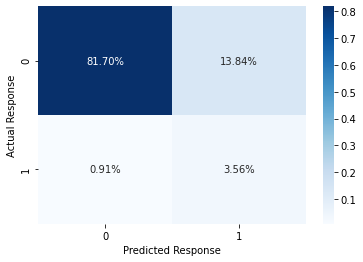

In [139]:
pred=clf_dt.predict(X_test)
cm = confusion_matrix(y_test, pred)
plot= plt.subplot()
sns.heatmap(cm/np.sum(cm), annot=True, ax = plot, fmt='.2%',cmap='Blues')
plot.set_xlabel('Predicted Response')
plot.set_ylabel('Actual Response')

### References



1.   https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02#:~:text=StandardScaler,-StandardScaler%20is%20the&text=StandardScaler%20standardizes%20a%20feature%20by,values%20by%20the%20standard%20deviation.
2.   https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis
3. https://www.investopedia.com/terms/v/variance-inflation-factor.asp
4. https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
5. https://www.analyticsvidhya.com/blog/2021/01/gaussian-naive-bayes-with-hyperpameter-tuning/
6. https://en.wikipedia.org/wiki/Gradient_boosting
7. https://analyticsindiamag.com/7-types-classification-algorithms/


